In [29]:
import os
import torch
import torchsig

import numpy as np
import torch.nn.functional as F
import torchsig.transforms as ST

# from datetime import datetime
from matplotlib import pyplot as plt
from models import CustomNetwork
from pathlib import Path
# from pytorch_lightning import LightningModule, Trainer
# from pytorch_lightning.callbacks import ModelCheckpoint
from scipy import signal as sp
# from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
# from sklearn.metrics import classification_report
# from torch import optim
from torch.utils.data import DataLoader
# from torchsig.datasets.sig53 import Sig53
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    SpectralInversion,
    TargetSNR,
    ComplexTo2D,
    AddNoise,
    RandAugment,
    RandomMagRescale,
    RollOff,
    RandomConvolve,
    RandomDropSamples,
)
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from tqdm import tqdm
from typing import List


In [30]:
dataset_path = "./dev_data/torchsig_test/gamutrf-sd-gr-ieee-wifi/"
dataset_path = "./data/gamutrf/gamutrf-sd-gr-ieee-wifi/"
num_iq_samples = 1024 # 1024*16# 
idx_to_class = {
  0: 'anom_wifi',
  1: 'mini2_telem',
  2: 'mini2_video',
  3: 'wifi6',
  4: 'wifi',
  5: 'fhss_css'
}

In [31]:
# transform = ST.Compose([
#     ST.Normalize(norm=np.inf),
#     ST.ComplexTo2D(),
# ])
transform = ST.Compose([
    #RandomApply(RandomFrequencyShift((-0.16, 0.16)), 0.7),
    # AddNoise(((-60, 35)),input_noise_floor_db=-100),
    #AddNoise(((50, 100))),

    
    RandomApply(
        RandomTimeShift(
            shift=(-int(num_iq_samples / 2), int(num_iq_samples / 2))
        ),
        0.25,
    ),
    RandomApply(RandomFrequencyShift(freq_shift=(-0.2, 0.2)), 0.25),
    RandomApply(
        RandomResample(
            rate_ratio=(0.8, 1.2), num_iq_samples=num_iq_samples
        ),
        0.99,
    ),
    RandomApply(SpectralInversion(), 0.5),
    AddNoise(
        noise_power_db=(0, 0), input_noise_floor_db=-100
    ),  # Set input noise floor very low because this transform sets the floor
    AddNoise(
        noise_power_db=(-40, 40), input_noise_floor_db=0
    ),  # Then add minimal noise without affecting SNR
    RandAugment(
        [
            RandomApply(
                RandomMagRescale(start=(0, 0.9), scale=(-4, 4)), 0.5
            ),
            RollOff(
                low_freq=(0.00, 0.05),
                upper_freq=(0.95, 1.00),
                low_cut_apply=0.5,
                upper_cut_apply=0.5,
                order=(6, 20),
            ),
            RandomConvolve(num_taps=(2, 5), alpha=(0.1, 0.4)),
            RayleighFadingChannel((0.001, 0.01)),
            RandomDropSamples(
                drop_rate=0.01,
                size=(1, 1),
                fill=["ffill", "bfill", "mean", "zero"],
            ),
            RandomPhaseShift((-1, 1)),
            IQImbalance(
                (-3, 3),
                (-np.pi * 1.0 / 180.0, np.pi * 1.0 / 180.0),
                (-0.1, 0.1),
            ),
        ],
        num_transforms=2,
    ),
])
dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    class_list = list(idx_to_class.values()),
    transform = transform,
    only_first_samples=True,
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

Class List: ['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']
len(dataset)=42777
{'anom_wifi': 20246, 'mini2_telem': 0, 'mini2_video': 0, 'wifi6': 0, 'wifi': 22531, 'fhss_css': 0}


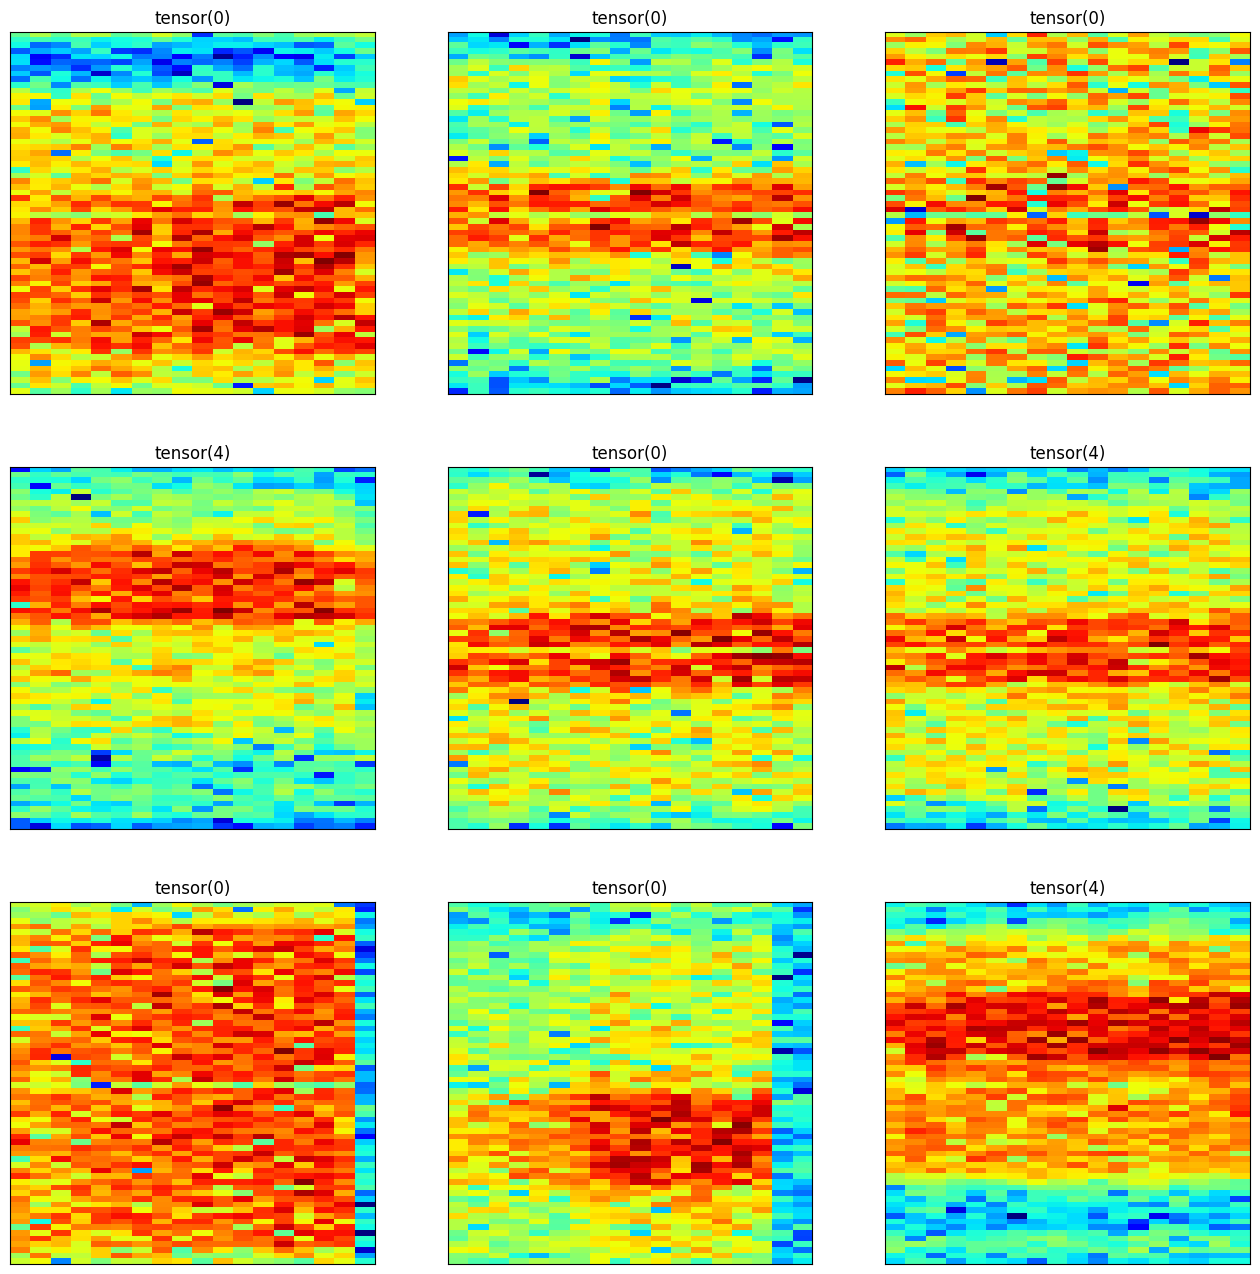

In [32]:
data_loader = DataLoader(
    dataset=dataset,
    batch_size=9,
    shuffle=True,
)

visualizer = SpectrogramVisualizer(
    data_loader=data_loader, 
    window=sp.windows.tukey(64, 0.25),#sp.windows.hamming(64),
    nperseg = 64
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 16)
    plt.show()
    break

# No Transform

In [ ]:
# transform = ST.Compose([
#     ST.Normalize(norm=np.inf),
#     ST.ComplexTo2D(),
# ])
transform = ST.Compose([
    #RandomApply(RandomFrequencyShift((-0.16, 0.16)), 0.7),
    # AddNoise(((-60, 35)),input_noise_floor_db=-100),
    #AddNoise(((50, 100))),

    # AddNoise(
    #     noise_power_db=(0, 0), input_noise_floor_db=-100
    # ),  # Set input noise floor very low because this transform sets the floor
    # AddNoise(
    #     noise_power_db=(-40, -20), input_noise_floor_db=0
    # ),  # Then add minimal noise without affecting SNR
])
dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    class_list = list(idx_to_class.values()),
    #transform = transform,
    only_first_samples=True,
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

In [ ]:
data_loader = DataLoader(
    dataset=dataset,
    batch_size=9,
    shuffle=True,
)

visualizer = SpectrogramVisualizer(
    data_loader=data_loader, 
    window=sp.windows.tukey(256, 0.25),#sp.windows.hamming(64),
    nperseg = 256
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 16)
    plt.show()
    break